In [14]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.interpolate import RegularGridInterpolator

In [2]:
hbarc = 0.2     # eV um
rho_T = 2.0e3   # Sphere density, kg/m^3
mAMU = 1.66e-27 # Neutron mass

In [3]:
rhoDM = 0.3e9    # dark matter mass density, eV/cm^3

vmin = 5e-5      # minimum velocity to consider, natural units (c)
vesc = 1.815e-3  # galactic escape velocity
v0 = 7.34e-4     # v0 parameter from Zurek group paper
ve = 8.172e-4    # ve parameter from Zurek group paper

In [4]:
def get_total_events(sphere_type, mx_gev, alpha_t, m_phi, q_thr, exposure):
    outdir = f'/home/yt388/palmer_scratch/data/mphi_{m_phi:.0e}'
    events = np.empty((mx_gev.size, alpha_t.size))

    for i, mx in enumerate(mx_gev):
        for j, alpha in enumerate(alpha_t):
            drdq_file = np.load(outdir + f'/drdq_{sphere_type}_{mx:.5e}_{alpha:.5e}_{m_phi:.0e}.npz', allow_pickle='True')

            # GeV; Counts/hour/GeV
            qq, drdq = drdq_file['q'], drdq_file['drdq']
            events[i][j] = get_nevents(qq, drdq, q_thr, exposure, project_z=True)
    
    return events

In [5]:
def get_nevents(q, drdq, q_thr, exposure, project_z=True):
    # <|cos(theta)|> = 0.5 if q is isotropic
    # so total `q` would look half as small in the z direction
    if project_z:
        q = q * 0.5
        
    drdq[q < q_thr] = 0
    total_rate = np.trapz(drdq, q)
    
    # Exposure in hours
    return total_rate * exposure

In [6]:
def get_limit(mx, alpha_n, events):
    cl = 3.0  # 95% CL without background
    
    ret = np.empty_like(mx)
    # Solve for parameters where `events` = cl
    for i, m in enumerate(mx):
        if np.sum(events[i]) < 1e-5:
            ret[i] = np.nan
        else:
            min_alpha_idx = np.argmin( np.abs( np.log10(events[i]) - np.log10((cl)) ))
            
            if events[i][min_alpha_idx] > 1e3:
                ret[i] = np.nan
            else:
                ret[i] = alpha_n[min_alpha_idx]                                  
    return ret

In [7]:
sphere_type= 'nanosphere'
R_um = 0.075      # Sphere radius, um
R = R_um / hbarc  # Radius in natural units, eV^-1
mx_gev  = np.logspace(-4, 10, 40)
alpha_t = np.logspace(-12, -4, 40)

In [8]:
q_thr = 25e3 / 1e9   # Assume 25 keV momentum threshold, in GeV
exposure = 24 * 30   # 1 sphere - month

# Has projected onto the z-axis
events_0      = get_total_events(sphere_type, mx_gev, alpha_t, 0, q_thr, exposure)
events_0_0001 = get_total_events(sphere_type, mx_gev, alpha_t, 1e-4, q_thr, exposure)
events_0_001  = get_total_events(sphere_type, mx_gev, alpha_t, 1e-3, q_thr, exposure)
events_0_01   = get_total_events(sphere_type, mx_gev, alpha_t, 1e-2, q_thr, exposure)
events_0_1    = get_total_events(sphere_type, mx_gev, alpha_t, 1e-1, q_thr, exposure)
events_1      = get_total_events(sphere_type, mx_gev, alpha_t, 1, q_thr, exposure)
events_10     = get_total_events(sphere_type, mx_gev, alpha_t, 10, q_thr, exposure)
events_100    = get_total_events(sphere_type, mx_gev, alpha_t, 100, q_thr, exposure)
events_1000   = get_total_events(sphere_type, mx_gev, alpha_t, 1000, q_thr, exposure)

Plot result

In [25]:
interp = RegularGridInterpolator((np.log10(mx_gev), np.log10(alpha_t)), np.log(events_0))

/tmp/ipykernel_4652/1097920863.py:1: RuntimeWarning: divide by zero encountered in log
  interp = RegularGridInterpolator((np.log10(mx_gev), np.log10(alpha_t)), np.log(events_0))


In [24]:
np.array(np.meshgrid(np.log10(mx_gev), np.log10(alpha_t))).shape

(2, 40, 40)

In [21]:
plt.contourf(mx_gev, alpha_t, np.log(interp(malpha)))

ValueError: The requested sample points xi have dimension 40, but this RegularGridInterpolator has dimension 2

/tmp/ipykernel_4652/135303561.py:4: RuntimeWarning: divide by zero encountered in log
  im0 = axs[0][0].contourf(mx_gev, alpha_t, np.log(events_1000.T),     vmax=vmax, vmin=vmin)
/tmp/ipykernel_4652/135303561.py:5: RuntimeWarning: divide by zero encountered in log
  im1 = axs[0][1].contourf(mx_gev, alpha_t, np.log(events_100.T),     vmax=vmax, vmin=vmin)
/tmp/ipykernel_4652/135303561.py:6: RuntimeWarning: divide by zero encountered in log
  im2 = axs[0][2].contourf(mx_gev, alpha_t, np.log(events_10.T),      vmax=vmax, vmin=vmin)
/tmp/ipykernel_4652/135303561.py:7: RuntimeWarning: divide by zero encountered in log
  im3 = axs[1][0].contourf(mx_gev, alpha_t, np.log(events_1.T),    vmax=vmax, vmin=vmin)
/tmp/ipykernel_4652/135303561.py:8: RuntimeWarning: divide by zero encountered in log
  im4 = axs[1][1].contourf(mx_gev, alpha_t, np.log(events_0_1.T),   vmax=vmax, vmin=vmin)
/tmp/ipykernel_4652/135303561.py:9: RuntimeWarning: divide by zero encountered in log
  im5 = axs[1][2].contourf(m

Text(0.5, 1.0, '$m_\\phi =$0 eV')

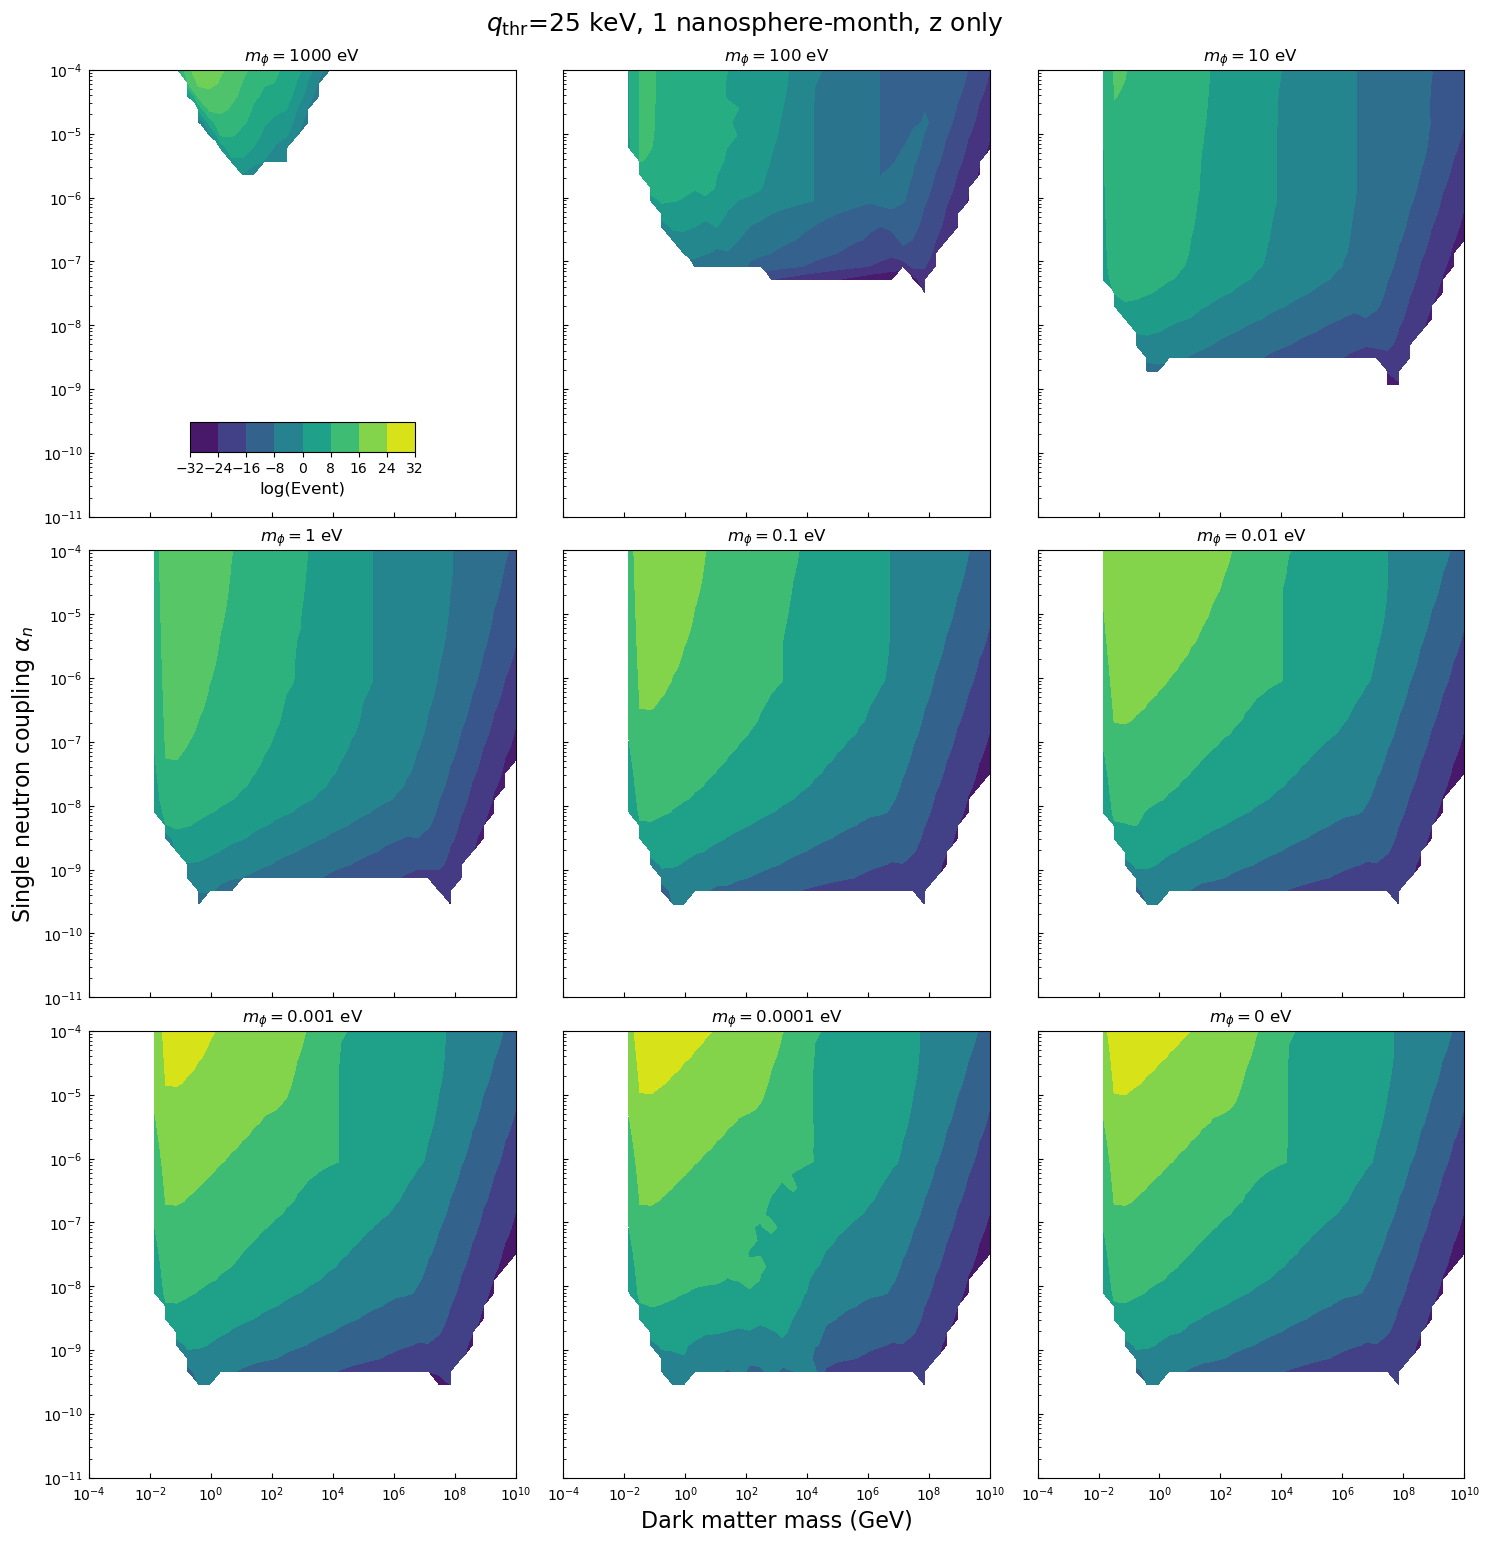

In [9]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
vmax, vmin = 32, -32

im0 = axs[0][0].contourf(mx_gev, alpha_t, np.log(events_1000.T),     vmax=vmax, vmin=vmin)
im1 = axs[0][1].contourf(mx_gev, alpha_t, np.log(events_100.T),     vmax=vmax, vmin=vmin)
im2 = axs[0][2].contourf(mx_gev, alpha_t, np.log(events_10.T),      vmax=vmax, vmin=vmin)
im3 = axs[1][0].contourf(mx_gev, alpha_t, np.log(events_1.T),    vmax=vmax, vmin=vmin)
im4 = axs[1][1].contourf(mx_gev, alpha_t, np.log(events_0_1.T),   vmax=vmax, vmin=vmin)
im5 = axs[1][2].contourf(mx_gev, alpha_t, np.log(events_0_01.T),  vmax=vmax, vmin=vmin)
im6 = axs[2][0].contourf(mx_gev, alpha_t, np.log(events_0_001.T), vmax=vmax, vmin=vmin)
im7 = axs[2][1].contourf(mx_gev, alpha_t, np.log(events_0_0001.T), vmax=vmax, vmin=vmin)
im8 = axs[2][2].contourf(mx_gev, alpha_t, np.log(events_0.T),      vmax=vmax, vmin=vmin)

for i, ax in enumerate(axs.flatten()):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-4, 1e10)
    ax.set_ylim(1e-11, 1e-4)
    ax.tick_params(axis='both', which='both', direction="in", pad=5)
    
    if i == 3:
        ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=16)
    if i == 7:
        ax.set_xlabel(r'Dark matter mass (GeV)', fontsize=16)


cax = fig.add_axes([0.13, 0.73, 0.15, 0.02]) # left, bottom, width, height
fig.colorbar(im8, cax=cax, orientation='horizontal').set_label(label='log(Event)', size=12)
fig.tight_layout()

fig.suptitle(r'$q_{\mathrm{thr}}$=25 keV, 1 nanosphere-month, z only', fontsize=18, y=1.025)

axs[0][0].set_title('$m_\phi =$1000 eV')
axs[0][1].set_title('$m_\phi =$100 eV')
axs[0][2].set_title('$m_\phi =$10 eV')
axs[1][0].set_title('$m_\phi =$1 eV')
axs[1][1].set_title('$m_\phi =$0.1 eV')
axs[1][2].set_title('$m_\phi =$0.01 eV')
axs[2][0].set_title('$m_\phi =$0.001 eV')
axs[2][1].set_title('$m_\phi =$0.0001 eV')
axs[2][2].set_title('$m_\phi =$0 eV')

In [10]:
q_thr = 100e3 / 1e9   # Assume 25 keV momentum threshold, in GeV
exposure = 24 * 30   # 1 sphere - month

events_0_100kev      = get_total_events(sphere_type, mx_gev, alpha_t, 0, q_thr, exposure)
events_0_0001_100kev = get_total_events(sphere_type, mx_gev, alpha_t, 1e-4, q_thr, exposure)
events_0_001_100kev  = get_total_events(sphere_type, mx_gev, alpha_t, 1e-3, q_thr, exposure)
events_0_01_100kev   = get_total_events(sphere_type, mx_gev, alpha_t, 1e-2, q_thr, exposure)
events_0_1_100kev    = get_total_events(sphere_type, mx_gev, alpha_t, 1e-1, q_thr, exposure)
events_1_100kev      = get_total_events(sphere_type, mx_gev, alpha_t, 1, q_thr, exposure)
events_10_100kev     = get_total_events(sphere_type, mx_gev, alpha_t, 10, q_thr, exposure)
events_100_100kev    = get_total_events(sphere_type, mx_gev, alpha_t, 100, q_thr, exposure)
events_1000_100kev   = get_total_events(sphere_type, mx_gev, alpha_t, 1000, q_thr, exposure)

/tmp/ipykernel_4652/2352636275.py:4: RuntimeWarning: divide by zero encountered in log
  im0 = axs[0][0].contourf(mx_gev, alpha_t, np.log(events_1000_100kev.T),     vmax=vmax, vmin=vmin)
/tmp/ipykernel_4652/2352636275.py:5: RuntimeWarning: divide by zero encountered in log
  im1 = axs[0][1].contourf(mx_gev, alpha_t, np.log(events_100_100kev.T),     vmax=vmax, vmin=vmin)
/tmp/ipykernel_4652/2352636275.py:6: RuntimeWarning: divide by zero encountered in log
  im2 = axs[0][2].contourf(mx_gev, alpha_t, np.log(events_10_100kev.T),      vmax=vmax, vmin=vmin)
/tmp/ipykernel_4652/2352636275.py:7: RuntimeWarning: divide by zero encountered in log
  im3 = axs[1][0].contourf(mx_gev, alpha_t, np.log(events_1_100kev.T),    vmax=vmax, vmin=vmin)
/tmp/ipykernel_4652/2352636275.py:8: RuntimeWarning: divide by zero encountered in log
  im4 = axs[1][1].contourf(mx_gev, alpha_t, np.log(events_0_1_100kev.T),   vmax=vmax, vmin=vmin)
/tmp/ipykernel_4652/2352636275.py:9: RuntimeWarning: divide by zero encoun

Text(0.5, 1.0, '$m_\\phi =$0 eV')

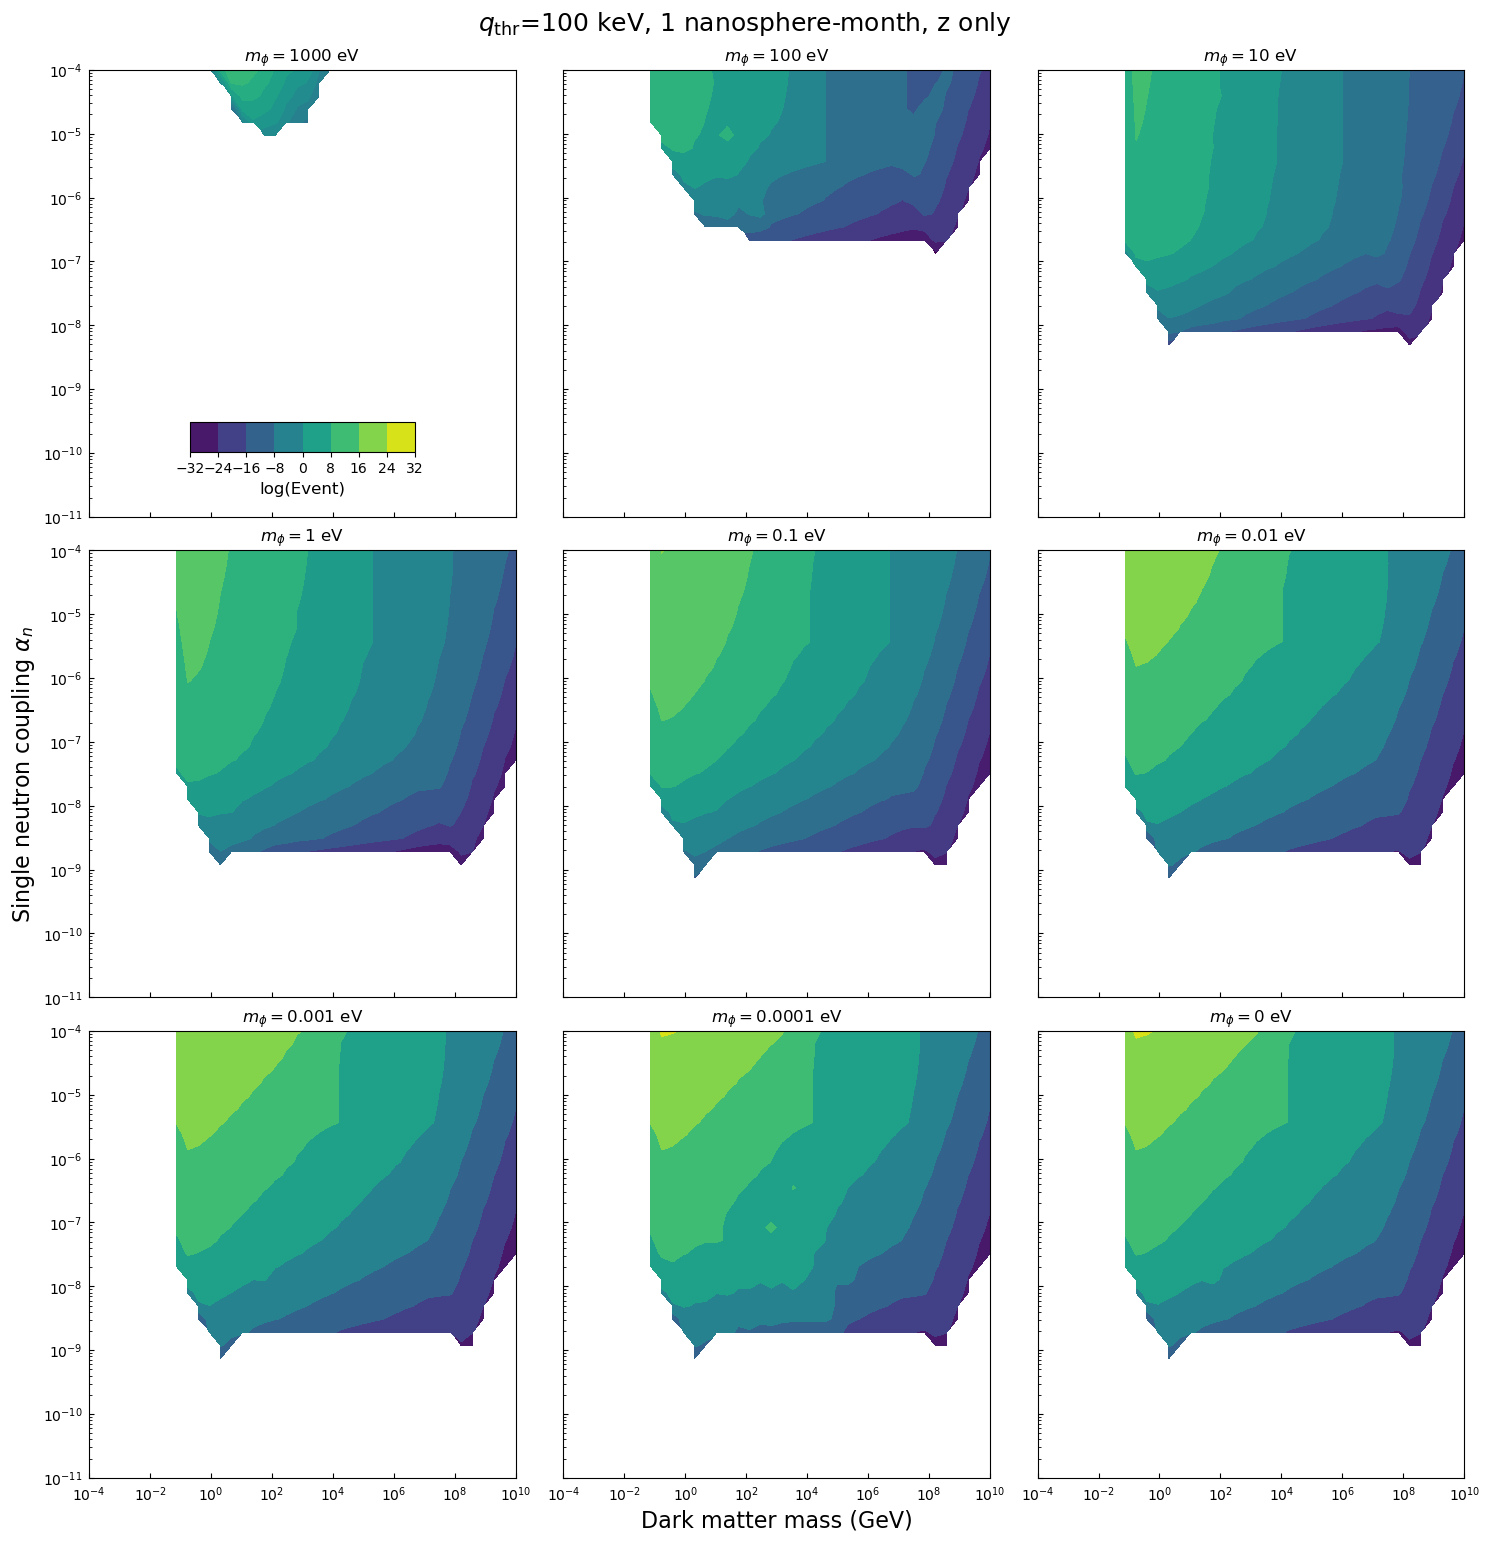

In [11]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
vmax, vmin = 32, -32

im0 = axs[0][0].contourf(mx_gev, alpha_t, np.log(events_1000_100kev.T),     vmax=vmax, vmin=vmin)
im1 = axs[0][1].contourf(mx_gev, alpha_t, np.log(events_100_100kev.T),     vmax=vmax, vmin=vmin)
im2 = axs[0][2].contourf(mx_gev, alpha_t, np.log(events_10_100kev.T),      vmax=vmax, vmin=vmin)
im3 = axs[1][0].contourf(mx_gev, alpha_t, np.log(events_1_100kev.T),    vmax=vmax, vmin=vmin)
im4 = axs[1][1].contourf(mx_gev, alpha_t, np.log(events_0_1_100kev.T),   vmax=vmax, vmin=vmin)
im5 = axs[1][2].contourf(mx_gev, alpha_t, np.log(events_0_01_100kev.T),  vmax=vmax, vmin=vmin)
im6 = axs[2][0].contourf(mx_gev, alpha_t, np.log(events_0_001_100kev.T), vmax=vmax, vmin=vmin)
im7 = axs[2][1].contourf(mx_gev, alpha_t, np.log(events_0_0001_100kev.T), vmax=vmax, vmin=vmin)
im8 = axs[2][2].contourf(mx_gev, alpha_t, np.log(events_0_100kev.T),      vmax=vmax, vmin=vmin)

for i, ax in enumerate(axs.flatten()):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-4, 1e10)
    ax.set_ylim(1e-11, 1e-4)
    ax.tick_params(axis='both', which='both', direction="in", pad=5)
    
    if i == 3:
        ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=16)
    if i == 7:
        ax.set_xlabel(r'Dark matter mass (GeV)', fontsize=16)


cax = fig.add_axes([0.13, 0.73, 0.15, 0.02]) # left, bottom, width, height
fig.colorbar(im8, cax=cax, orientation='horizontal').set_label(label='log(Event)', size=12)
fig.tight_layout()

fig.suptitle(r'$q_{\mathrm{thr}}$=100 keV, 1 nanosphere-month, z only', fontsize=18, y=1.025)

axs[0][0].set_title('$m_\phi =$1000 eV')
axs[0][1].set_title('$m_\phi =$100 eV')
axs[0][2].set_title('$m_\phi =$10 eV')
axs[1][0].set_title('$m_\phi =$1 eV')
axs[1][1].set_title('$m_\phi =$0.1 eV')
axs[1][2].set_title('$m_\phi =$0.01 eV')
axs[2][0].set_title('$m_\phi =$0.001 eV')
axs[2][1].set_title('$m_\phi =$0.0001 eV')
axs[2][2].set_title('$m_\phi =$0 eV')

In [12]:
q_thr = 500e3 / 1e9  # Assume 25 keV momentum threshold, in GeV
exposure = 24 * 30   # 1 sphere - month

events_0_500kev      = get_total_events(sphere_type, mx_gev, alpha_t, 0, q_thr, exposure)
events_0_0001_500kev = get_total_events(sphere_type, mx_gev, alpha_t, 1e-4, q_thr, exposure)
events_0_001_500kev  = get_total_events(sphere_type, mx_gev, alpha_t, 1e-3, q_thr, exposure)
events_0_01_500kev   = get_total_events(sphere_type, mx_gev, alpha_t, 1e-2, q_thr, exposure)
events_0_1_500kev    = get_total_events(sphere_type, mx_gev, alpha_t, 1e-1, q_thr, exposure)
events_1_500kev      = get_total_events(sphere_type, mx_gev, alpha_t, 1, q_thr, exposure)
events_10_500kev     = get_total_events(sphere_type, mx_gev, alpha_t, 10, q_thr, exposure)
events_100_500kev    = get_total_events(sphere_type, mx_gev, alpha_t, 100, q_thr, exposure)
events_1000_500kev   = get_total_events(sphere_type, mx_gev, alpha_t, 1000, q_thr, exposure)

/tmp/ipykernel_4652/370089711.py:4: RuntimeWarning: divide by zero encountered in log
  im0 = axs[0][0].contourf(mx_gev, alpha_t, np.log(events_1000_500kev.T),     vmax=vmax, vmin=vmin)
/tmp/ipykernel_4652/370089711.py:5: RuntimeWarning: divide by zero encountered in log
  im1 = axs[0][1].contourf(mx_gev, alpha_t, np.log(events_100_500kev.T),     vmax=vmax, vmin=vmin)
/tmp/ipykernel_4652/370089711.py:6: RuntimeWarning: divide by zero encountered in log
  im2 = axs[0][2].contourf(mx_gev, alpha_t, np.log(events_10_500kev.T),      vmax=vmax, vmin=vmin)
/tmp/ipykernel_4652/370089711.py:7: RuntimeWarning: divide by zero encountered in log
  im3 = axs[1][0].contourf(mx_gev, alpha_t, np.log(events_1_500kev.T),    vmax=vmax, vmin=vmin)
/tmp/ipykernel_4652/370089711.py:8: RuntimeWarning: divide by zero encountered in log
  im4 = axs[1][1].contourf(mx_gev, alpha_t, np.log(events_0_1_500kev.T),   vmax=vmax, vmin=vmin)
/tmp/ipykernel_4652/370089711.py:9: RuntimeWarning: divide by zero encountered 

Text(0.5, 1.0, '$m_\\phi =$0 eV')

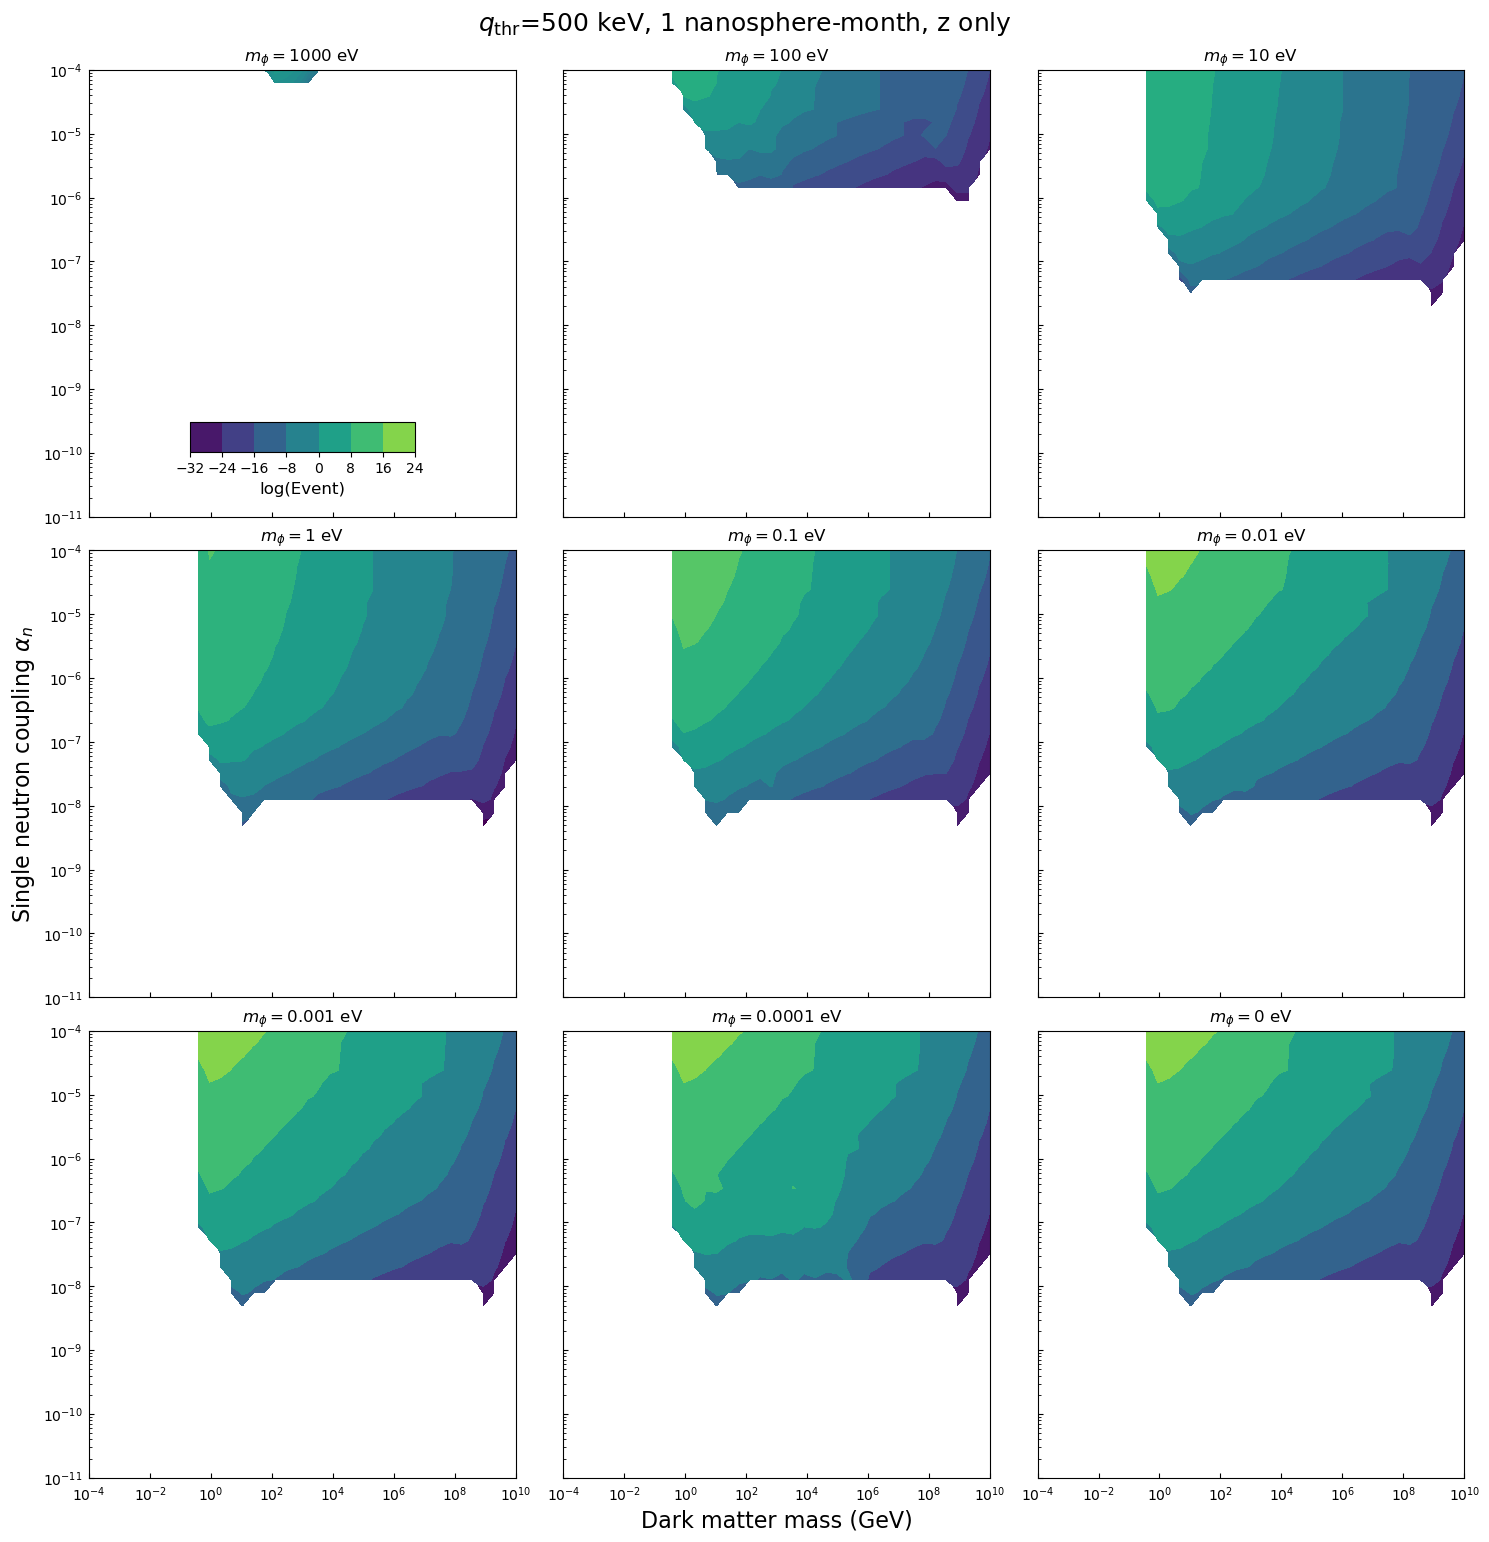

In [13]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
vmax, vmin = 32, -32

im0 = axs[0][0].contourf(mx_gev, alpha_t, np.log(events_1000_500kev.T),     vmax=vmax, vmin=vmin)
im1 = axs[0][1].contourf(mx_gev, alpha_t, np.log(events_100_500kev.T),     vmax=vmax, vmin=vmin)
im2 = axs[0][2].contourf(mx_gev, alpha_t, np.log(events_10_500kev.T),      vmax=vmax, vmin=vmin)
im3 = axs[1][0].contourf(mx_gev, alpha_t, np.log(events_1_500kev.T),    vmax=vmax, vmin=vmin)
im4 = axs[1][1].contourf(mx_gev, alpha_t, np.log(events_0_1_500kev.T),   vmax=vmax, vmin=vmin)
im5 = axs[1][2].contourf(mx_gev, alpha_t, np.log(events_0_01_500kev.T),  vmax=vmax, vmin=vmin)
im6 = axs[2][0].contourf(mx_gev, alpha_t, np.log(events_0_001_500kev.T), vmax=vmax, vmin=vmin)
im7 = axs[2][1].contourf(mx_gev, alpha_t, np.log(events_0_0001_500kev.T), vmax=vmax, vmin=vmin)
im8 = axs[2][2].contourf(mx_gev, alpha_t, np.log(events_0_500kev.T),      vmax=vmax, vmin=vmin)

for i, ax in enumerate(axs.flatten()):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-4, 1e10)
    ax.set_ylim(1e-11, 1e-4)
    ax.tick_params(axis='both', which='both', direction="in", pad=5)
    
    if i == 3:
        ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=16)
    if i == 7:
        ax.set_xlabel(r'Dark matter mass (GeV)', fontsize=16)


cax = fig.add_axes([0.13, 0.73, 0.15, 0.02]) # left, bottom, width, height
fig.colorbar(im8, cax=cax, orientation='horizontal').set_label(label='log(Event)', size=12)
fig.tight_layout()

fig.suptitle(r'$q_{\mathrm{thr}}$=500 keV, 1 nanosphere-month, z only', fontsize=18, y=1.025)

axs[0][0].set_title('$m_\phi =$1000 eV')
axs[0][1].set_title('$m_\phi =$100 eV')
axs[0][2].set_title('$m_\phi =$10 eV')
axs[1][0].set_title('$m_\phi =$1 eV')
axs[1][1].set_title('$m_\phi =$0.1 eV')
axs[1][2].set_title('$m_\phi =$0.01 eV')
axs[2][0].set_title('$m_\phi =$0.001 eV')
axs[2][1].set_title('$m_\phi =$0.0001 eV')
axs[2][2].set_title('$m_\phi =$0 eV')

Get the 95% CL upper limit

In [ ]:
alpha_lim = []
for events in [events_0, events_0_0001, events_0_001, events_0_01, events_0_1, events_1, events_10, events_100]:
    lim = get_limit(mx_gev, alpha_t, events)
    alpha_lim.append(lim)

In [ ]:
m_phi = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
max_alpha = alpha_lim[0][-1]
fig, ax = plt.subplots()

for i, alpha in enumerate(alpha_lim):
    mphi = m_phi[i]
    alpha[alpha < alpha_lim[0]] = alpha_lim[0][alpha < alpha_lim[0]]
    ax.loglog(mx_gev, np.nan_to_num(alpha, nan=max_alpha), label=f'$m_\phi =${mphi}')

ax.legend(frameon=False)
ax.set_ylim(1e-12, max_alpha)
ax.set_xlim(1e-4, 1e10)

In [ ]:
alpha_lim_0_01 = get_limit(mx_gev, alpha_t, events_0_01)

max_alpha = alpha_lim_0_01[-1]
fig, ax = plt.subplots()

ax.loglog(mx_gev, np.nan_to_num(alpha_lim_0_01, nan=max_alpha), 'k-', label='25 keV')

ax.set_ylim(1e-12, max_alpha)
ax.set_xlim(1e-3, 5e9)

ax.legend(frameon=False)
ax.set_title(r'1 nanosphere-month, $m_\phi =$0.01 eV', fontsize=14)
ax.set_xlabel(r'Dark matter mass (GeV)', fontsize=14)
ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)

ax.tick_params(axis='both', which='both', direction="in", pad=5)

In [ ]:
m_phi = 0
outdir = f'/home/yt388/microspheres/impulse/data/mphi_{m_phi:.0e}'

q_thr = 25e3 / 1e9   # Assume 25 keV momentum threshold, in GeV
exposure = 24 * 30   # 1 sphere - month

npts = 40
mx_real, alpha_real, events = np.empty((npts, npts)), np.empty((npts, npts)), np.empty((npts, npts))

## TODO
# Read in real mx and alpha (calculation for massless and 1e-2 have wrong mx_gev)
# I have also changed `alpha_t` to `alpha_n` in the saved data for later calculations
for i, mx in enumerate(mx_gev):
    for j, alpha in enumerate(alpha_t):
        drdq_file = np.load(outdir + f'/drdq_{sphere_type}_{mx:.5e}_{alpha:.5e}_{m_phi:.0e}.npz', allow_pickle='True')
        
        # GeV; Counts/hour/GeV
        qq, drdq = drdq_file['q'], drdq_file['drdq']
        events[i][j] = get_total_events(qq, drdq, q_thr, exposure)

In [ ]:
plt.figure(figsize=(8, 6))
plt.contourf(mx_gev, alpha_t, np.log(events.T))
plt.colorbar().set_label(label='log(Event)', size=14)
plt.yscale('log')
plt.xscale('log')

# plt.xlim(1e-2, 1e10)
# plt.ylim(1e-10, 1e-5)

plt.title(r'$q_{\mathrm{thr}}$=25 keV, 1 sphere-month, massless mediator', fontsize=14)
plt.xlabel(r'Dark matter mass (GeV)', fontsize=14)
plt.ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)

In [ ]:
alpha_lim_massless = get_limit(mx_gev, alpha_t, events)

max_alpha = alpha_lim_massless[-1]

fig, ax = plt.subplots()

ax.loglog(mx_gev, np.nan_to_num(alpha_lim_massless, nan=max_alpha), 'k:', label=r'$m_\phi = $0 eV')
ax.loglog(mx_gev, np.nan_to_num(alpha_lim_0_01, nan=max_alpha), 'b-', label=r'$m_\phi = $0.01 eV')

ax.set_ylim(1e-12, max_alpha)
ax.set_xlim(1e-3, 5e9)

ax.legend(frameon=False)
ax.set_title(r'$q_{\mathrm{thr}}$=25 keV, 1 nanosphere-month', fontsize=14)
ax.set_xlabel(r'Dark matter mass (GeV)', fontsize=14)
ax.set_ylabel(r'Single neutron coupling $\alpha_n$', fontsize=14)

ax.tick_params(axis='both', which='both', direction="in", pad=5)